<a href="https://colab.research.google.com/github/deepakmeena61/Image-Colorisation/blob/main/image_colorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorisation using U-Net and GAN

Baseline model: It is approaching the problem as classification task but there are some uncertainities. So, I approached the question using linear regression by doing a few more tweaks.
But I am going to use a different strategy.

I am going to use the pix2pix strategy for Image coolorisation, which suggests those images not only learn maping but they also learn a loss function to train this mapping. This is a better approach with less dataset and better results.

- Installing libraries

In [1]:
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from torch import nn, optim
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

- Preparing the dataset

In [2]:
#!pip install fastai==2.4

In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

- Selecting a portion consisting 15000 images out of the COCO dataset

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
paths = glob.glob(coco_path + "/*.jpg") # Getting all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 15000, replace=False) # Selecting 15000 images randomly
rand_idxs = np.random.permutation(15000)
train = paths_subset[rand_idxs[:10000]] # Selecting 10000 images for training set
valid = paths_subset[rand_idxs[10000:12500]] # Selecting 2500 images for validation set
test = paths_subset[rand_idxs[12500:]] # Selecting 2500 images for training set
print(len(train), len(valid), len(test))

10000 2500 2500


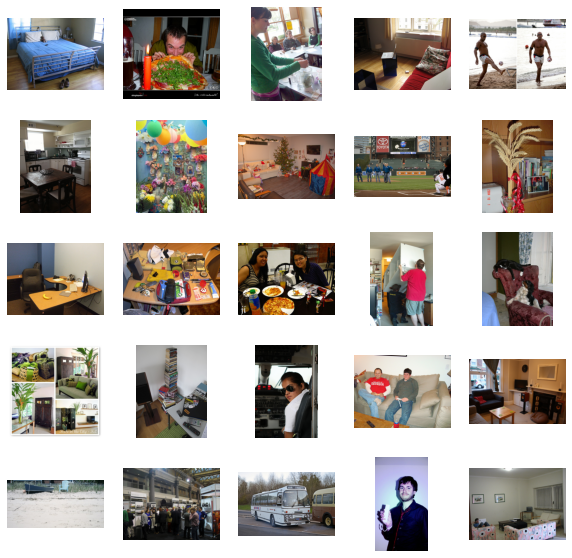

In [5]:
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_samples in zip(axes.flatten(), train):
    ax.imshow(Image.open(img_samples))
    ax.axis("off")

- Making dataset by resizing the images and flipping horizontally(only train) and then reas an RGB image. Further, converting it to L*a*b color space and separating the grayscale(L) channel and the color channel as inputs and outputs respectively.

Data augmentation increases the number of examples in the training dataset while also introducing more variety in what the model sees and learns from. This makes difficult for model to simply memorize mappings simultaneously, encouraging model to learn general patterns.

This can be achieved by doing simple geometric transformations, such as flipping, rotating, cropping or translating the images.

Bicubic interpolation preserves the fine details better by considering 4x4 pixels around it unlike bilinear. This increases the accuracy of the model.

In [6]:
class MakingDataset(Dataset):
  def __init__(self, location, dset = 'train'):
    self.dset = dset
    self.location = location
    self.size = 256

    if dset == 'train':
      self.transform = transforms.Compose([transforms.Resize((self.size, self.size), Image.BICUBIC),
                                            transforms.RandomHorizontalFlip()]) # Data Augmentation
    elif dset == 'valid':
      self.transform = transforms.Resize((self.size, self.size), Image.BICUBIC)

    elif dset == 'test':
      self.transform = transforms.Resize((self.size, self.size), Image.BICUBIC)
    
  def __getitem__(self, index):
    picture = Image.open(self.location[index]).convert("RGB")
    picture = self.transform(picture)
    picture = np.array(picture)
    rgb_lab = rgb2lab(picture).astype("float32") # Converting RGB to L*a*b
    rgb_lab = transforms.ToTensor()(rgb_lab)
    L = rgb_lab[[0], ...]/50. - 1. # Between -1 and 1
    ab = rgb_lab[[1,2], ...]/110. # Betweem -1 and 1

    return {'L':L, 'ab':ab}
  
  def __len__(self):
    return len(self.location)
  
def create_dataloader(batch_size = 16, n_workers = 2, pin_memory = True, **kwargs):
  dataset = MakingDataset(**kwargs)
  dataloader = DataLoader(dataset, batch_size = batch_size, num_workers = n_workers, pin_memory = pin_memory)
  return dataloader

In [7]:
train_dl = create_dataloader(location=train, dset='train')
valid_dl = create_dataloader(location=valid, dset='valid')
test_dl = create_dataloader(location=test, dset='test')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(valid_dl), len(test_dl))

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
625 157 157


- Creating Generator

We are using the Unet Generator for our GAN. 

At each iteration, it adds down- and up-sampling modules to the left and right of the middle module, respectively, until it reaches the input module and output module. This creates the U-Net from the middle portion of the network (down in the U shape). 

We are going eight layers down, so if we start with a 256 by 256 image, we will obtain a 1 by 1 image in the middle of the U-Net, and it will then be up-sampled to create a 256 by 256 image (with two channels).

In [8]:
class UnetElements(nn.Module):
  def __init__(self, layer_input, layer_output, input_channel = None, submodule = None, 
               dropout = False, innermost = False, outermost = False):
    super().__init__()
    self.outermost = outermost
    if input_channel is None: input_channel = layer_input
    down_conv = nn.Conv2d(input_channel, layer_output, kernel_size = (4,4),
                          stride = 2, padding = 1, bias = False)
    down_activ = nn.LeakyReLU(0.2, True)
    down_norm = nn.BatchNorm2d(layer_output)
    up_activ = nn.ReLU(True)
    up_norm = nn.BatchNorm2d(layer_input)

    if innermost:
      up_conv  = nn.ConvTranspose2d(layer_output, layer_input, kernel_size = (4,4),
                                    stride = 2, padding = 1)

      down = [down_activ, down_conv]
      up = [up_activ, up_conv, up_norm]
      model = down + up

    elif outermost:
      up_conv = nn.ConvTranspose2d(layer_output*2, layer_input,
                                   kernel_size = (4,4), stride = 2, padding = 1)
      activ = nn.Tanh()
      
      down = [down_conv]
      up = [up_activ, up_conv, activ]
      model = down + [submodule] + up

    else:
      up_conv = nn.ConvTranspose2d(layer_output*2, layer_input, kernel_size = (4,4),
                                   stride = 2, padding = 1)
      activ = nn.Dropout(0.5)
      
      down = [down_activ, down_conv, down_norm]
      up = [up_activ, up_conv, up_norm]
      if dropout: up += [activ]
      model = down + [submodule] + up
    self.model = nn.Sequential(*model)

  def forward(self, m):
    if self.outermost:
      return self.model(m)
    else:
      return torch.cat([m, self.model(m)], 1)

class Unet(nn.Module):
  def __init__(self, input_channel=1, output_channel=2, n_loops = 8, n_filters = 64):
    super().__init__()
    unet_mod = UnetElements(n_filters*8, n_filters*8, innermost = True)
    for _ in range(n_loops - 5):
      unet_mod = UnetElements(n_filters*8, n_filters*8, submodule = unet_mod, dropout = True)
    o_filters = n_filters*8
    for _ in range(3):
      unet_mod = UnetElements(o_filters//2, o_filters, submodule = unet_mod)
      o_filters //= 2

    self.model = UnetElements(output_channel, o_filters, input_channel = input_channel, submodule = unet_mod, outermost = True)

  def forward(self, x):
    return self.model(x) 

In [9]:
Unet(1,2)

Unet(
  (model): UnetElements(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetElements(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetElements(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetElements(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), b

- Creating Discriminator

The discriminator is pretty simple comparedt to the generator, it's built by stacking up Conv -> BatchNorm -> LeakyReLU to decide whether the input image is fake or real.

In a vanilla discriminator, the model produces a single scalar number that indicates how much it believes the input, which is the entire image, is real or fake. In a patch discriminator, the model produces a single number for each patch of the input image, let's say 70 by 70 pixels, and determines whether or not each one is fake independently. It makes sense to me to employ such a model for the colorization work because the local adjustments the model must do are crucial, and perhaps deciding on the entire image as in a vanilla discriminator cannot handle the nuances of this assignment.

In [10]:
class PatchD(nn.Module):
  def __init__(self, input_channel, n_filters = 64, n_loops = 3):
    super().__init__()
    model = [self.layers(input_channel, n_filters, norm = False)]
    for n in range(n_loops):
      if n == (n_loops - 1):
        model += [self.layers(n_filters*2**n, n_filters*2**(n+1), stride = 1)]
      else:
        model += [self.layers(n_filters*2**n, n_filters*2**(n+1), stride = 2)]
    
    model += [self.layers(n_filters*2**n_loops, 1, stride = 1, norm = False, activ = False)]

    self.model = nn.Sequential(*model)

  def layers(self, layer_input, layer_output, kernel_size = (4,4),
             stride = 2, padding = 1, norm = True, activ = True):
    layer = [nn.Conv2d(layer_input, layer_output, kernel_size,
                       stride, padding, bias = not norm)]
    if norm: layer += [nn.BatchNorm2d(layer_output)]
    if activ: layer += [nn.LeakyReLU(0.2, True)]
    
    return nn.Sequential(*layer)
  
  def forward(self, m):
    return self.model(m)

In [11]:
PatchD(3)

PatchD(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequenti

- Loss

In [12]:
class Loss(nn.Module):
  def __init__(self, mode = 'vanilla', real = 1.0, fake = 0.0):
    super().__init__()
    self.register_buffer('real', torch.tensor(real))
    self.register_buffer('fake', torch.tensor(fake))
    if mode == 'vanilla':
      self.loss = nn.BCEWithLogitsLoss()
    elif mode == 'lsgan':
      self.loss = nn.MSELoss()
    
  def obtain_labels(self, predicted, is_real):
    if is_real:
      labels = self.real
    else:
      labels = self.fake
    return labels.expand_as(predicted)
  
  def __call__(self, predicted, is_real):
    labels = self.obtain_labels(predicted, is_real)
    loss = self.loss(predicted, labels)
    return loss

- Weights 

In [13]:
def init_weights(net, init = 'norm', gain = 0.02):
  
  def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and 'Conv' in classname:
      if init == 'norm':
        nn.init.normal_(m.weight.data, mean=0.0, std=gain)
      elif init == 'xavier':
        nn.init.xavier_normal_(m.weight.data, gain=gain)

      if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant_(m.bias.data, 0.0)
    elif 'BatchNorm2d' in classname:
      nn.init.normal_(m.weight.data, 1.0, gain)
      nn.init.constant_(m.bias.data, 0.0)
    
  net.apply(init_func)
  print(f"Initialisation with {init}")
  return net
  
def init_model(model, device):
  model = model.to(device)
  model = init_weights(model)
  return model

- Combining everything together

In [14]:
class MainModel(nn.Module):
  def __init__(self, net_Generator = None, learning_rate = 2e-4,
               beta1 = 0.5, beta2 = 0.999, lambda_L1 = 100.0):
    super().__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.lambda_L1 = lambda_L1

    if net_Generator is None:
      self.net_Generator = init_model(Unet(input_channel=1, output_channel=2, n_loops=8, n_filters=64), self.device)
    else:
      self.net_Generator = net_Generator.to(self.device)
    self.net_Discriminator = init_model(PatchD(input_channel=3, n_loops=3, n_filters=64), self.device)
    self.GAN_Loss = Loss(mode = 'vanilla').to(self.device)
    self.L1_Loss = nn.L1Loss()
    self.optimize_Generator = optim.Adam(self.net_Generator.parameters(), lr = learning_rate, betas=(beta1,beta2))
    self.optimize_Discriminator = optim.Adam(self.net_Discriminator.parameters(), lr = learning_rate, betas=(beta1, beta2))
    
  def acquire_input(self, data):
    self.L = data['L'].to(self.device)
    self.ab = data['ab'].to(self.device)

  def forward(self):
    self.fake_ab = self.net_Generator(self.L)

  def backward_Generator(self):
    fake_image = torch.cat([self.L, self.fake_ab], dim=1)
    fake_predicted = self.net_Discriminator(fake_image)
    self.Generator_GAN_Loss = self.GAN_Loss(fake_predicted, True)
    self.Generator_L1_Loss = self.L1_Loss(self.fake_ab, self.ab)*self.lambda_L1
    self.Generator_total_loss = self.Generator_GAN_Loss + self.Generator_L1_Loss
    self.Generator_total_loss.backward()

  def backward_Discriminator(self):
    real_image = torch.cat([self.L, self.ab], dim=1)
    real_predicted = self.net_Discriminator(real_image)
    self.Discriminator_loss_real = self.GAN_Loss(real_predicted, True)
    fake_image = torch.cat([self.L, self.fake_ab], dim=1)
    fake_predicted = self.net_Discriminator(fake_image.detach())
    self.Discriminator_loss_fake = self.GAN_Loss(fake_predicted, False)
    self.Discriminator_total_loss = (self.Discriminator_loss_real + self.Discriminator_loss_fake)*0.5
    self.Discriminator_total_loss.backward()

  def set_grad(self, model, requires_grad = True):
    for p in model.parameters():
      p.requires_grad = requires_grad
  
  def optimize(self):
    self.forward()
    self.net_Discriminator.train()
    self.set_grad(self.net_Discriminator, True)
    self.optimize_Discriminator.zero_grad()
    self.backward_Discriminator()
    self.optimize_Discriminator.step()

    self.net_Generator.train()
    self.set_grad(self.net_Discriminator, False)
    self.optimize_Generator.zero_grad()
    self.backward_Generator()
    self.optimize_Generator.step()

- Printing Losses

In [34]:
class calc_loss:
  def __init__(self):
    self.zero()

  def zero(self):
    self.count, self.average, self.sum = [0.]*3

  def calc(self, value, count = 1):
    self.count += count
    self.sum += count * value
    self.average = self.sum / self.count

def loss_dict():
  Generator_GAN_Loss = calc_loss()
  Generator_L1_Loss = calc_loss()
  Generator_total_loss = calc_loss()
  Discriminator_loss_fake = calc_loss()
  Discriminator_loss_real = calc_loss()
  Discriminator_total_loss = calc_loss()

  return{'Generator_GAN_Loss' : Generator_GAN_Loss,
         'Generator_L1_Loss' : Generator_L1_Loss,
         'Generator_total_loss' : Generator_total_loss,
         'Discriminator_loss_fake' : Discriminator_loss_fake,
         'Discriminator_loss_real' : Discriminator_loss_real,
         'Discriminator_total_loss' : Discriminator_total_loss}

def loss_updation(model, dictionary, count):
  for name_of_loss, calculation_of_loss in dictionary.items():
    loss = getattr(model, name_of_loss)
    calculation_of_loss.calc(loss.item(), count = count)

def loss_function(dictionary):
    for name_of_loss, calculation_of_loss in dictionary.items():
        print(f"{name_of_loss}: {calculation_of_loss.average:.5f}")

- Visualizing Images 

In [16]:
def lab_to_rgb(L, ab):
  L = (L + 1.0) * 50.0
  ab = ab * 110.0
  Lab_image = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
  RGB_images = []
  for i in Lab_image:
    RGB = lab2rgb(i)
    RGB_images.append(RGB)
  return np.stack(RGB_images, axis = 0)

def visualize(model, data):
  model.net_Generator.eval()
  with torch.no_grad():
    model.acquire_input(data)
    model.forward()
  model.net_Generator.train()
  fake_ab = model.fake_ab.detach()
  real_ab = model.ab
  L = model.L
  fake_images = lab_to_rgb(L, fake_ab)
  real_images = lab_to_rgb(L, real_ab)
  fig = plt.figure(figsize=(10,7))
  for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(fake_images[i])
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(real_images[i])
    ax.axis("off")
  plt.show()

- Training

Initialisation with norm
Initialisation with norm


  0%|          | 0/625 [00:00<?, ?it/s]


Epoch 1/50
Generator_GAN_Loss: 0.86916
Generator_L1_Loss: 10.59548
Generator_total_loss: 11.46464
Discriminator_loss_fake: 0.79775
Discriminator_loss_real: 0.81587
Discriminator_total_loss: 0.80681


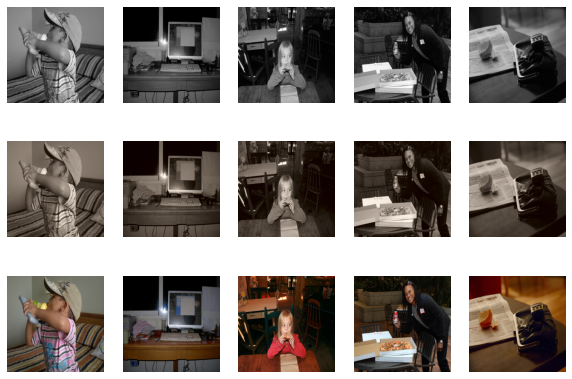


Epoch 1/50
Generator_GAN_Loss: 0.98181
Generator_L1_Loss: 9.75986
Generator_total_loss: 10.74167
Discriminator_loss_fake: 0.66444
Discriminator_loss_real: 0.68660
Discriminator_total_loss: 0.67552


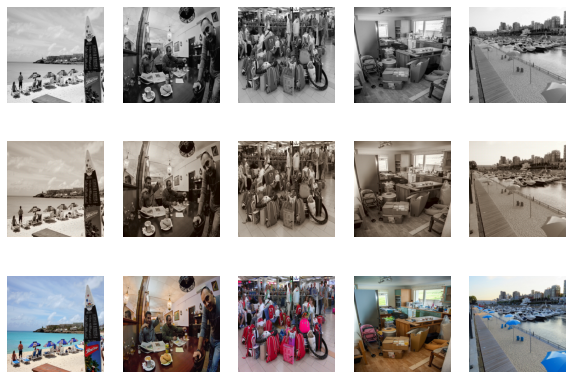


Epoch 1/50
Generator_GAN_Loss: 1.15102
Generator_L1_Loss: 9.44168
Generator_total_loss: 10.59270
Discriminator_loss_fake: 0.58150
Discriminator_loss_real: 0.59831
Discriminator_total_loss: 0.58991


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 101 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


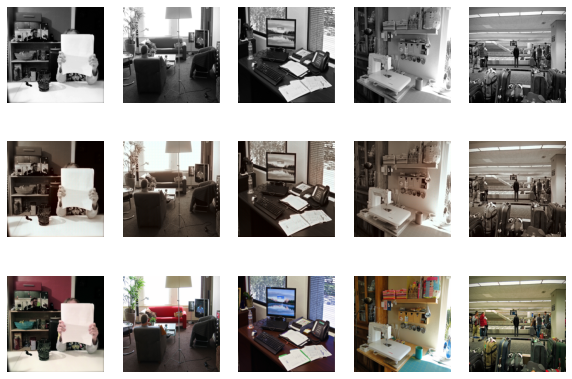

KeyboardInterrupt: ignored

In [35]:
def training_model(model, train, epochs, checkpoint = 300):
  data = next(iter(valid_dl))
  for e in range(epochs):
    dictionary = loss_dict()
    i = 0
    for data in tqdm(train_dl):
      model.acquire_input(data)
      model.optimize()
      loss_updation(model, dictionary, count = data['L'].size(0))
      i = i + 1
      if i % checkpoint == 0:
        print(f'\nEpoch {e+1}/{epochs}')
        loss_function(dictionary)
        visualize(model, data) 

model = MainModel()
training_model(model, train_dl, 50)